In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

# DataSet Description

* transactions occured in 2 days
* 492 frauds of total 284'807 transactions
* unbalanced data -> 0.172% frauds (total 2 classes: value 1 -> fraud)
    * do not use confusion matrix accuracy (due to unbalanced data)
    * Use Area Under the Precision-Recall Curve (AUPRC)
* columns: V1, ...V28
* result of PCA trafo
* without PCA: Fetures Time [s] (delta bzw. each transaction & Amount (transaction amount)
* Target data: class

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

Text(0.5, 1.0, 'Visualize target data')

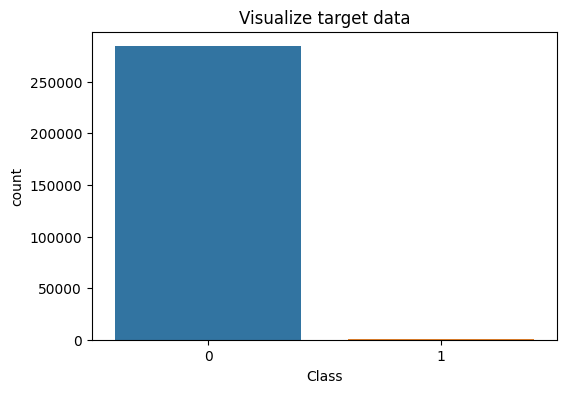

In [5]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.countplot(x='Class', data = df)
ax.set_title('Visualize target data')

# unbalanced data

<Axes: xlabel='Time', ylabel='Density'>

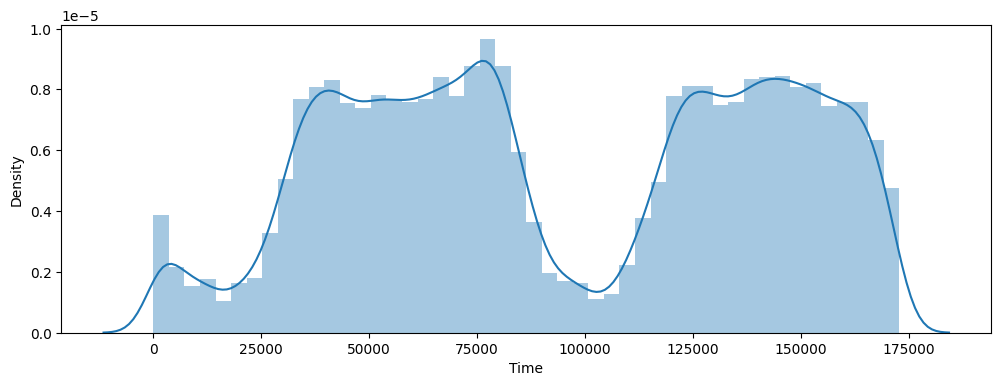

In [6]:
##
# 2 days of data -> 48 hours data

plt.figure(figsize=(12,4))
sns.distplot(df['Time'], bins = 48)

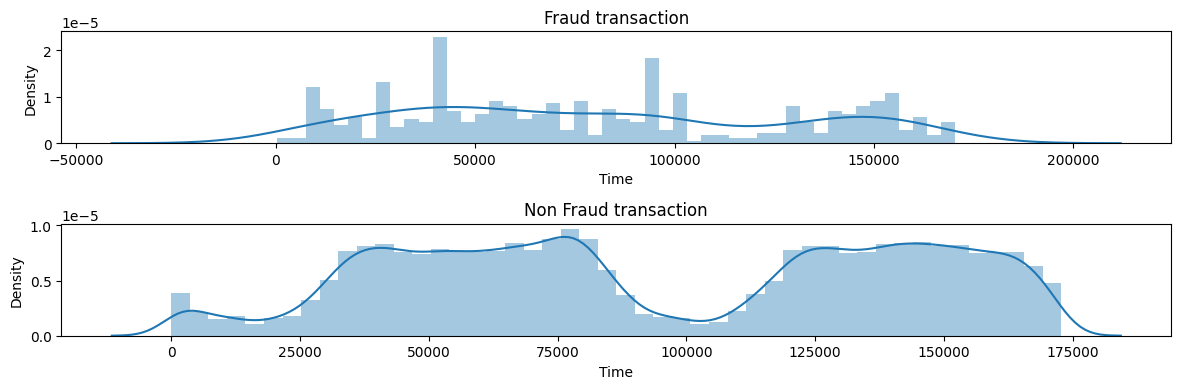

In [7]:
fig, axs = plt.subplots(2,1, figsize=(12,4))
sns.distplot(df[df['Class']==1]['Time'], bins=48, ax=axs[0])
sns.distplot(df[df['Class']==0]['Time'], bins=48, ax=axs[1])
axs[0].set_title('Fraud transaction')
axs[1].set_title('Non Fraud transaction')
plt.tight_layout()

<Axes: xlabel='Amount', ylabel='Density'>

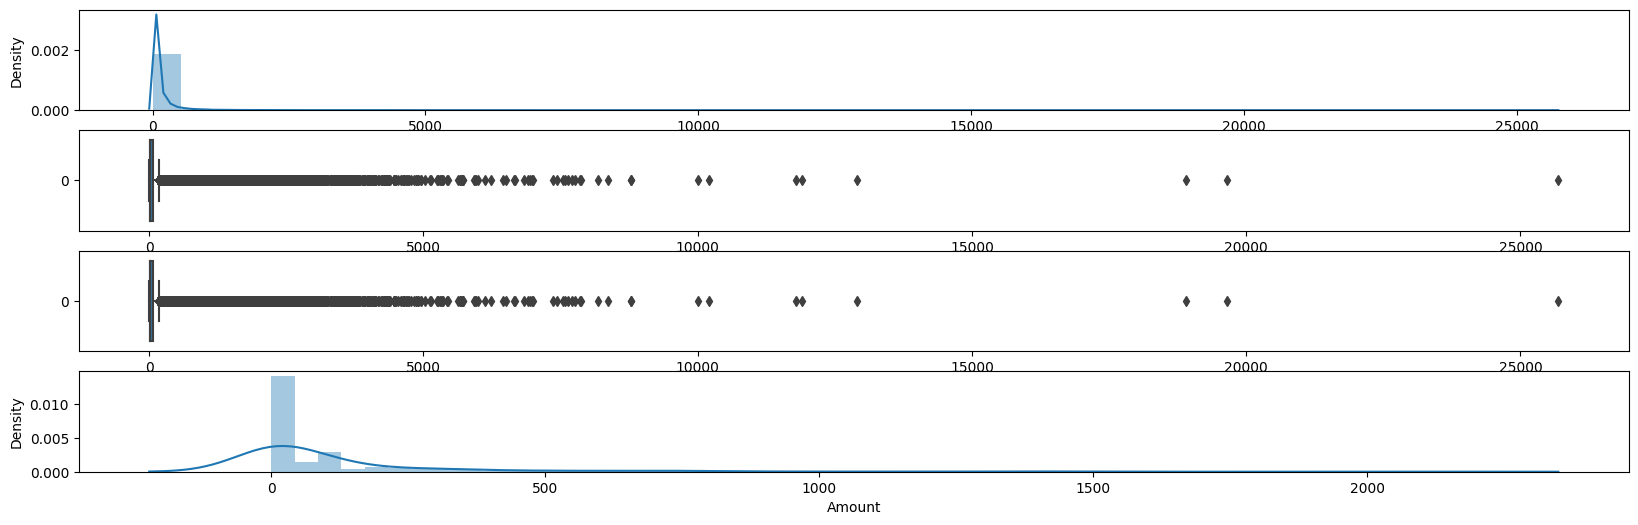

In [8]:
fig, axs = plt.subplots(4,1, figsize=(20,6))
sns.distplot(df['Amount'], ax=axs[0])
sns.boxplot(df['Amount'], ax=axs[1], orient='h')
sns.boxplot(df[df['Class']==0]['Amount'], ax=axs[2], orient='h')
sns.distplot(df[df['Class']==1]['Amount'], ax=axs[3])

<Axes: >

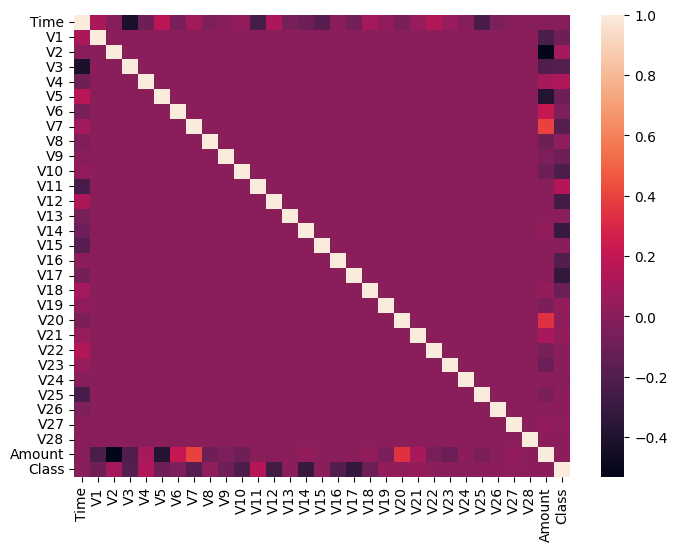

In [9]:
# Data Correlation -> since PCA is done, there should not be any correlation

corr = df.corr()

fig, ax = plt.subplots(1,1, figsize=(8,6))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

# Data Preprocessing

* column Amount -> z-score normalization
* splitting data into feature & target data set
* splitting data into train & test set
* handle missing values -> impute mean values of column

In [10]:
# z-score normalization
scaler = StandardScaler()
df['Amount']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [11]:
# splitting data into feature & target data set
X = df.drop('Class', axis=1)
y = df['Class']

In [12]:
# Splitting into train & test data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# impute mean values of column for missing values in feature data set

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

In [14]:
# scale imputed features

scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

In [15]:
X_test_scaled

array([[-1.12439981, -8.4294878 ,  5.26603668, ..., -4.91408171,
        -3.1444534 ,  1.20222813],
       [-1.06636257,  0.17523146, -1.68426209, ...,  0.0994836 ,
         0.31109426,  1.88055411],
       [-1.25119308,  0.71590036, -0.36334475, ...,  0.02746028,
         0.01709468, -0.24721348],
       ...,
       [ 1.00221456,  0.02250105, -0.06826748, ...,  0.87078148,
         1.07275263, -0.34887754],
       [-0.75267505, -0.25069035,  0.60734232, ...,  0.09834779,
        -0.81117285, -0.36645233],
       [-0.96943026, -0.80955191,  0.60791566, ...,  0.3057984 ,
        -1.82971929,  3.56055607]])

In [16]:
X_test_imputed

array([[ 4.15050000e+04, -1.65265066e+01,  8.58497180e+00, ...,
        -2.01857525e+00, -1.04280417e+00,  1.10283362e+00],
       [ 4.42610000e+04,  3.39812064e-01, -2.74374524e+00, ...,
         4.09958027e-02,  1.02037825e-01,  1.72625520e+00],
       [ 3.54840000e+04,  1.39959027e+00, -5.90701288e-01, ...,
         1.14086454e-02,  4.63414166e-03, -2.29288721e-01],
       ...,
       [ 1.42491000e+05,  4.04414982e-02, -1.09736789e-01, ...,
         3.57844730e-01,  3.54379443e-01, -3.22723995e-01],
       [ 5.91570000e+04, -4.95047586e-01,  9.91480934e-01, ...,
         4.05292111e-02, -2.69775457e-01, -3.38876264e-01],
       [ 4.88640000e+04, -1.59048567e+00,  9.92415466e-01, ...,
         1.25749856e-01, -6.07225509e-01,  3.27027611e+00]])

In [17]:
# handle missing values in y
y_train_imputed_testscaler= scaler.fit_transform(y_train.values.reshape(-1,1))

In [18]:
y_train_imputed_testscaler

array([[-0.0416202],
       [-0.0416202],
       [-0.0416202],
       ...,
       [-0.0416202],
       [-0.0416202],
       [-0.0416202]])

In [19]:
y_train_imputed = y_train.fillna(y_train.mean())
y_train_imputed

223361    0
165061    0
238186    0
150562    0
138452    0
         ..
119879    0
259178    0
131932    0
146867    0
121958    0
Name: Class, Length: 227845, dtype: int64